In [3]:
#Import the necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import glob #used to create a list for all the files in the directory
import random
import os

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG,Image
import tensorflow as tf

In [4]:
print(tf.__version__)

2.15.0


In [6]:
from glob import glob
images=glob("train/**/**")

(-0.5, 47.5, 47.5, -0.5)

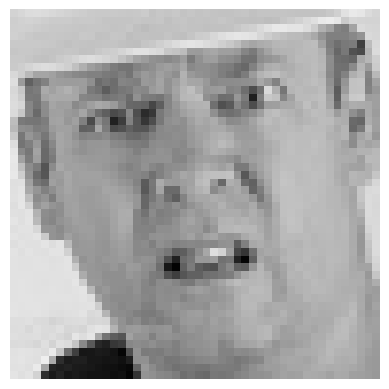

In [16]:
plt.imshow(cv2.imread(images[4]))
plt.axis('off')

In [18]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_data=datagen_train.flow_from_directory("train",
                                                 target_size=(img_size,img_size),
                                                 color_mode="grayscale",
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=True)
validation_data=datagen_train.flow_from_directory("test",
                                                 target_size=(img_size,img_size),
                                                 color_mode="grayscale",
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
def convolution_layer(input_tensor,filters,kernel_size):
    x=Conv2D(filters=filters,kernel_size=kernel_size,padding='same')(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)
    
    return x

In [20]:
def dense_f(input_tensor,nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    
    return x

In [21]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=convolution_layer(inputs,32,(3,3))
    conv_2=convolution_layer(inputs,64,(5,5))
    conv_3=convolution_layer(inputs,128,(3,3))
    
    flatten = Flatten()(conv_3)
    dense_1=dense_f(flatten,256)
    output=Dense(7,activation='softmax')(dense_1)
    model=Model(inputs=[inputs],outputs=[output])
    model.compile(loss=['categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [23]:
model=model_fer((48,48,1))

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       3328      
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

In [25]:
epochs = 15
steps_per_epoch=train_data.n//train_data.batch_size
validation_steps=validation_data.n//validation_data.batch_size
checkpoint=ModelCheckpoint("model_weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks=[checkpoint]

In [26]:
history=model.fit(
x=train_data,
steps_per_epoch=steps_per_epoch,
epochs=epochs,
validation_data=validation_data,
validation_steps=validation_steps,
callbacks=callbacks)

Epoch 1/15


448/448 [==============================] - ETA: 0s - loss: 1.6641 - accuracy: 0.3662
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 675s 1s/step - loss: 1.6641 - accuracy: 0.3662 - val_loss: 1.6802 - val_accuracy: 0.3041
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3666 - accuracy: 0.4824
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 139s 311ms/step - loss: 1.3666 - accuracy: 0.4824 - val_loss: 1.6287 - val_accuracy: 0.3523
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2192 - accuracy: 0.5434
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 139s 311ms/step - loss: 1.2192 - accuracy: 0.5434 - val_loss: 1.7995 - val_accuracy: 0.3152
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.5897
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 1

In [27]:
model.evaluate(validation_data)

113/113 [==============================] - 7s 61ms/step - loss: 1.8296 - accuracy: 0.4971


[1.8296178579330444, 0.4970743954181671]

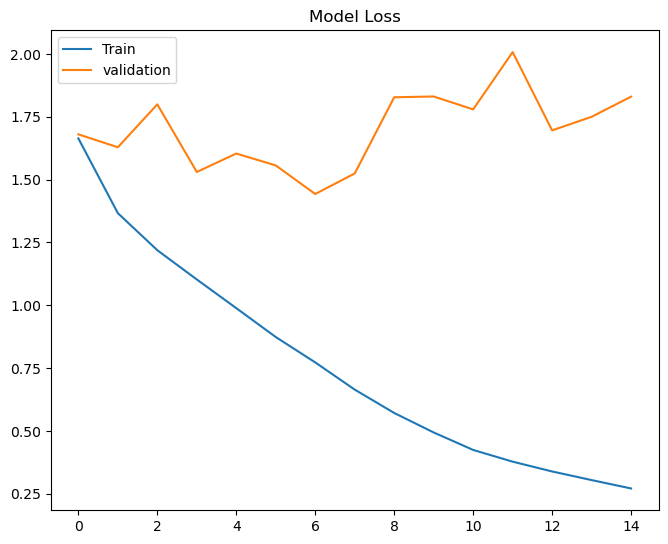

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.3)

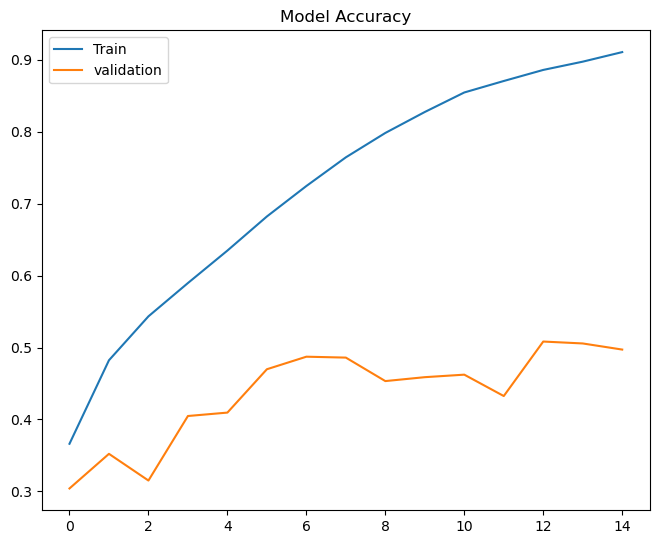

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.3)

In [32]:
model_json=model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)